### This notebook investigates the difference in returns between the ETF XIV and roll rules meant to replicate XIV methodology applied to VIX Futures contracts

In [1]:
%pylab inline
import mapping
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import os
import re

Populating the interactive namespace from numpy and matplotlib


/home/matthew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/matthew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
xiv = pd.read_csv("data/XIV.csv", index_col=0, parse_dates=[0])
xiv.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-30,9.565,9.772,9.542,9.557,9.557,252000
2010-12-01,9.957,9.993,9.783,9.787,9.787,484000
2010-12-02,9.924,10.429,9.924,10.429,10.429,62000
2010-12-03,10.423,11.041,10.423,11.041,11.041,168000
2010-12-06,10.946,11.278,10.946,11.252,11.252,232000


## Read VIX Futures contract data

In [3]:
contract_dates = pd.read_csv("data/ux_contract_dates.csv", index_col=0, parse_dates=[1, 2])
contract_dates.head()

,last_trade,first_notice
contract,,
2004UXK,2004-05-18,2004-05-18
2004UXM,2004-06-15,2004-06-15
2004UXN,2004-07-13,2004-07-13
2004UXQ,2004-08-17,2004-08-17
2004UXU,2004-09-14,2004-09-14


In [4]:
contract_dates = contract_dates.min(axis=1)
contract_dates.head()

contract
2004UXK   2004-05-18
2004UXM   2004-06-15
2004UXN   2004-07-13
2004UXQ   2004-08-17
2004UXU   2004-09-14
dtype: datetime64[ns]

In [5]:
def name_func(fstr):
    name_map = {"VX": "UX"}
    ast = os.path.split(fstr)[1].split(".")[0]
    ast = ast[3:] + name_map[ast[:2]] + ast[2]
    return ast

files = [os.path.join('data', f) for f in os.listdir('data') if re.match("VX", f)]
prices = mapping.util.read_price_data(files, name_func).loc[:, "Settle"]
prices.head(n=10)

date        contract
2009-06-09  2010UXF      0.00
2009-06-10  2010UXF      0.00
2009-06-11  2010UXF      0.00
2009-06-12  2010UXF      0.00
2009-06-15  2010UXF      0.00
2009-06-16  2010UXF      0.00
2009-06-17  2010UXF     30.70
2009-06-18  2010UXF     30.10
2009-06-19  2010UXF     30.25
2009-06-22  2010UXF     30.60
Name: Settle, dtype: float64

# XIV Methodology

The prospectus for XIV detailing the methodology can be found [here](http://app.velocitysharesetns.com/files/prospectus/PRICING_SUPPLEMENT_No__VLS_ETN-1_A31_long_form_2.PDF).
A general overview of the methodology is

>The return on the ETNs is linked to the daily performance of one of the Indices. Each of the Indices
models returns from a long position in VIX futures contracts that is rolled continuously throughout the period
between futures expiration dates. The S&P 500 VIX Short-Term Futures™ Index ER measures the return from a
rolling long position in the first and second month VIX futures contracts, and rolls continuously throughout each
month from the first month VIX futures contract into the second month VIX futures contract. ...

>As described in more detail below, the roll for each VIX futures contract occurs on each Index Business
Day according to a pre-determined schedule that has the effect of keeping constant the weighted average maturity of
the relevant VIX futures contracts. The constant weighted average maturity for the futures underlying the S&P 500
VIX Short-Term Futures™ Index ER is one month...

### Formula

For any business day $t$, the level of the Index is calculated as follows:

$IndexER_{t} = IndexER_{t-1} * (1 + CDR_{t})$

$CDR_{t} = \frac{TDWO_{t}}{TDWI_{t-1}} -1$

$TDWO_{t} = CRW_{1, t-1} * DCRP_{1, t} + CRW_{2, t-1} * DCRP_{2, t}$

$TDWI_{t-1} = CRW_{1, t-1} * DCRP_{1, t-1} + CRW_{2, t-1} * DCRP_{2, t-1}$

$CRW_{1, t} = 100 * \frac{dr}{dt}$

$CRW_{2, t} = 100 * \frac{dt - dr}{dt}$

where

- $IndexER_{t}$ is the Index Excess Return on the preceding business day
- $CDR_{t}$ is the Contract Daily Return
- $TDWO_{t}$ is the Total Dollar Weight Obtained on $t$
- $TDWI_{t}$ is the Total Dollar Weight Invested on $t-1$
- $CRW_{i, t}$ is the Contract Roll Weight of the ith VIX Futures Contract on date $t$
- $DCRP_{i, t}$ is the Daily Contract Reference Price of the ith VIX Futures Contract on date $t$
- $dt$ is the total number of business days in the current Roll Period beginning with, and including, the starting CBOE VIX Futures Settlement Date and ending with, but excluding, the following CBOE VIX Futures Settlement Date. The number of business days will not change for purposes of this calculation in cases of a new holiday introduced intra-month or an unscheduled market closure.
- $dr$ is the total number of business days within a roll period beginning with, and including, the following business day and ending with, but excluding, the following CBOE VIX Futures Settlement Date. The number of business days includes a new holiday introduced intra-month up to the business day preceding such a holiday.

> The Roll Period for each Index starts on the Tuesday prior to the monthly CBOE VIX Futures Settlement
Date (the Wednesday falling 30 calendar days before the S&P 500 option expiration for the following month), and
runs through the Tuesday prior to the subsequent month’s CBOE VIX Futures Settlement Date. Thus, the Indices
are rolling on a continual basis. On the business day after the current Roll Period ends the following Roll Period
will begin. ...

> At the close on the Tuesday corresponding to the start of the Roll Period, all of the weight is allocated to
the first month contract. On each subsequent business day a fraction of the first month VIX futures contracts are
sold and an equal notional amount of the second month VIX futures contracts is bought. The fraction, or quantity, is
proportional to the number of first month VIX futures contracts as of the previous index roll day, and inversely
proportional to the length of the current Roll Period. In this way the initial position in the first month contract is
progressively moved to the second month over the course of the month, until the next following Roll Period starts
when the old second month VIX futures contract becomes the new first month VIX futures contract.

> **In addition to the transactions described above, the weight of each index component is also adjusted every
day to ensure that the change in total dollar exposure for the index is only due to the price change of each contract
and not due to using a different weight for a contract trading at a higher price.**

## Generate roll rules and instrument weights

In [6]:
def continuous_transition(timestamp, contract_dates, curve_maturity, generic_name,
                          holidays=None, validate_inputs=None):
    # curve maturity is an integer representing the constant maturity point to target,
    # e.g. 1, 2, 3
    
    if not holidays:
        holidays = []

    next_cntrc_dates = contract_dates.loc[contract_dates > timestamp]
    next_date = next_cntrc_dates.iloc[0].date()
    prev_date = contract_dates.loc[contract_dates <= timestamp].iloc[-1].date()
    contract_names = next_cntrc_dates.index

    total_days = np.busday_count(prev_date, next_date, holidays=holidays)

    remaining_days = np.busday_count(timestamp.date(), next_date, holidays=holidays) - 1

    weight_first = remaining_days / total_days
    weight_second = 1 - weight_first

    cwts = [(generic_name, contract_names[curve_maturity - 1], weight_first, timestamp),
            (generic_name, contract_names[curve_maturity], weight_second, timestamp)]

    return cwts

In [7]:
dates = xiv.index

weights = mapping.mappings.roller(
    dates, contract_dates, continuous_transition, curve_maturity=1, generic_name="UX"
)

In [8]:
weights.head(n=10)

generic                UX
date       contract      
2010-11-30 2010UXZ   0.56
           2011UXF   0.44
2010-12-01 2010UXZ   0.52
           2011UXF   0.48
2010-12-02 2010UXZ   0.48
           2011UXF   0.52
2010-12-03 2010UXZ   0.44
           2011UXF   0.56
2010-12-06 2010UXZ   0.40
           2011UXF   0.60

In [9]:
# needed because of https://github.com/pandas-dev/pandas/issues/21200
ux_rets = prices.groupby(level=-1).apply(lambda x: x.pct_change())

ux_rets = ux_rets.loc[(dates, slice(None))]
xiv_synthetic_rets = -mapping.util.calc_rets(ux_rets, weights)

In [10]:
ux_rets.head()

date        contract
2010-11-30  2010UXZ     0.081585
            2011UXF     0.053061
            2011UXG     0.036398
            2011UXH     0.031540
            2011UXJ     0.033149
Name: Settle, dtype: float64

In [11]:
xiv_synthetic_rets.head()

,UX
date,
2010-11-30,-0.069035
2010-12-01,0.048673
2010-12-02,0.081699
2010-12-03,0.038429
2010-12-06,0.024347


In [12]:
xiv_rets = xiv.loc[:, "Adj Close"].pct_change()
xiv_rets.head()

Date
2010-11-30         NaN
2010-12-01    0.024066
2010-12-02    0.065597
2010-12-03    0.058683
2010-12-06    0.019111
Name: Adj Close, dtype: float64

In [13]:
rets = pd.concat([xiv_rets, xiv_synthetic_rets], axis=1)
rets.columns = ["XIV", "Synthetic XIV"]
rets.head()

,XIV,Synthetic XIV
2010-11-30,NaN,-0.069035
2010-12-01,0.024066,0.048673
2010-12-02,0.065597,0.081699
2010-12-03,0.058683,0.038429
2010-12-06,0.019111,0.024347


The synthetic returns below do not included the fees associated with XIV, and therefore diverge over time. 

> On any calendar day (the “**calculation day**”), the Daily Investor Fee for any series of ETNs will be equal to the product of (1)
the Closing Indicative Value for that series on the immediately preceding calendar day times (2) the Daily ETN Performance
for that series on the calculation day times (3)(a) the Daily Investor Fee Factor for that series divided by (b) 365.

> The “**Daily Investor Fee Factor**” will be equal to (i) 0.0089 for each of the Long ETNs, (ii) 0.0135 for each of the Inverse
ETNs and (iii) 0.0165 for each of the 2x Long ETNs.

> **If the level of the Index decreases or does not increase sufficiently in the case of the Long ETNs or 2x Long ETNs or if
it increases or does not decrease sufficiently in the case of the Inverse ETNs (in each case in addition to the Daily
Accrual) to offset the sum of the Daily Investor Fees (and in the case of Early Redemption, the Early Redemption
Charge) over the term of the ETNs, you will receive less than the principal amount of your investment at maturity or
upon early redemption or acceleration of the ETNs.** See “Risk Factors — Even if the closing level of the Index on the
applicable Valuation Date exceeds (or is less than in the case of the Inverse ETNs) the initial closing level of the applicable
underlying Index on the date of your investment, you may receive less than the principal amount of your ETNs” and
“Hypothetical Examples” in this pricing supplement for additional information on how the Daily Investor Fee affects the
overall value of the ETNs. 

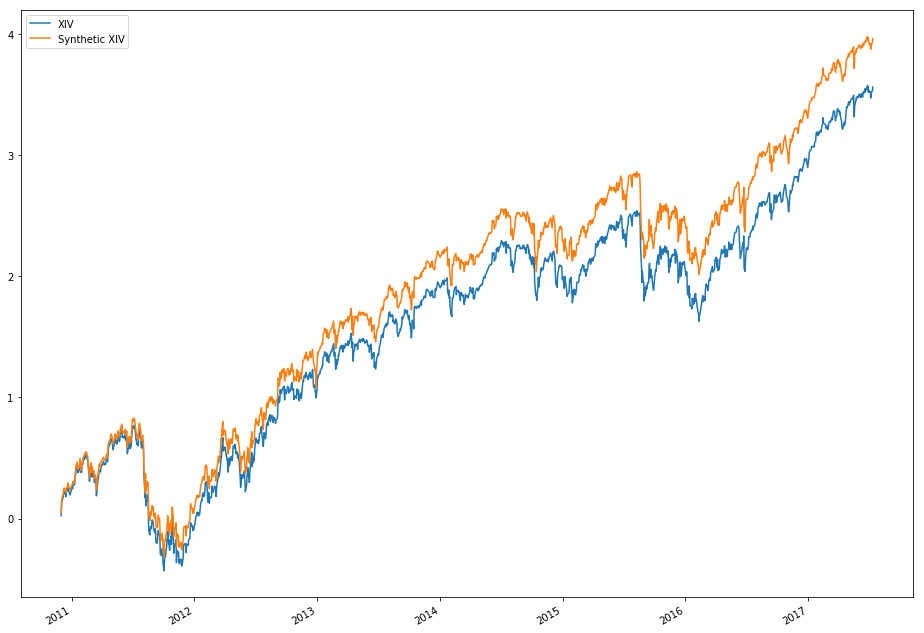

In [14]:
rets.iloc[1:].cumsum().plot(figsize=(16, 12))

However over shorter horizons the returns track reasonably well. One thing to note is that the synthetic returns are using the settlement prices for the UX Futures Contracts which settle at 3:15 p.m. Chicago Time whereas XIV returns are from NASDAQ closing prices at 4:00 p.m. Eastern Time

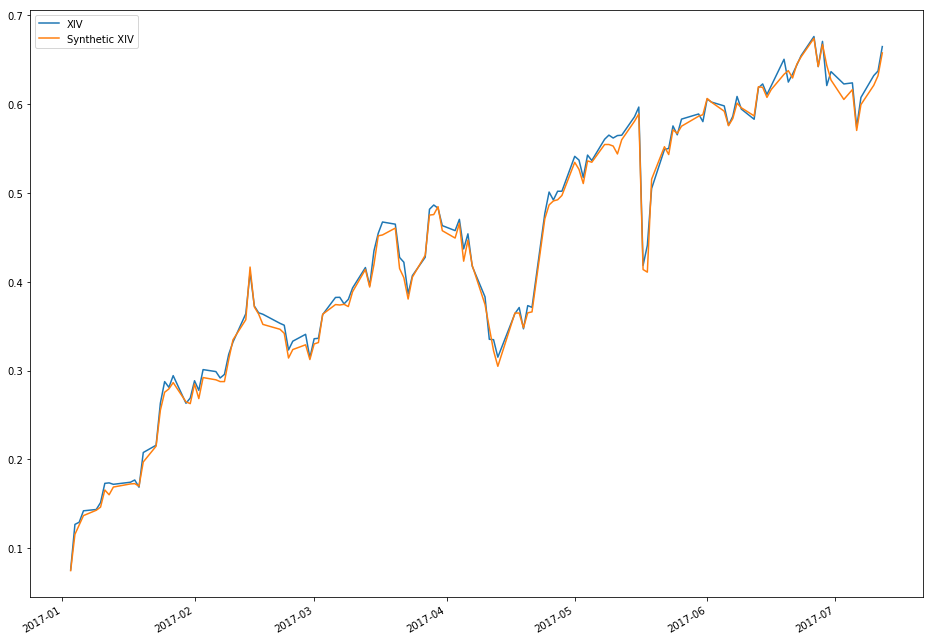

In [15]:
rets.loc["2017"].cumsum().plot(figsize=(16, 12))

# Analyze the curve

Compare the volality, cumulative return and IR of targetting different spots on the VIX curve

In [16]:
cboe = mcal.get_calendar("CFE")
ux_trading_days = cboe.schedule(start_date=xiv.index[0], end_date=xiv.index[-1]).index

In [17]:
cols = pd.MultiIndex.from_product([["UX1", "UX2", "UX3"], ['front', 'back']])
idx = [-1, 0]
transition = pd.DataFrame([[1.0, 0.0, 1.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 1.0, 0.0, 1.0]],
                          index=idx, columns=cols)
pre_expiry_roll = mapping.mappings.roller(ux_trading_days, contract_dates, mapping.mappings.static_transition,
                                          transition=transition)
pre_expiry_roll.head(n=6)

generic              UX1  UX2  UX3
date       contract               
2010-11-30 2010UXZ   1.0  0.0  0.0
           2011UXF   0.0  1.0  0.0
           2011UXG   0.0  0.0  1.0
2010-12-01 2010UXZ   1.0  0.0  0.0
           2011UXF   0.0  1.0  0.0
           2011UXG   0.0  0.0  1.0

In [18]:
FILL_LIMIT = 1

rets = mapping.util.reindex(ux_rets, pre_expiry_roll.index, limit=1)
pre_expiry_rets = -mapping.util.calc_rets(rets, pre_expiry_roll)
pre_expiry_rets.head()

,UX1,UX2,UX3
date,,,
2010-11-30,-0.081585,-0.053061,-0.036398
2010-12-01,0.056034,0.040698,0.025878
2010-12-02,0.093607,0.070707,0.058824
2010-12-03,0.040302,0.036957,0.028226
2010-12-06,0.023622,0.024831,0.016598


In [19]:
weights_2nd = mapping.mappings.roller(
    dates, contract_dates, continuous_transition, curve_maturity=2, generic_name="UX"
)
rets = mapping.util.reindex(ux_rets, weights_2nd.index, limit=1)
const_2nd_rets = -mapping.util.calc_rets(rets, weights_2nd)

weights_3rd = mapping.mappings.roller(
    dates, contract_dates, continuous_transition, curve_maturity=3, generic_name="UX"
)
rets = mapping.util.reindex(ux_rets, weights_3rd.index, limit=1)
const_3rd_rets = -mapping.util.calc_rets(rets, weights_3rd)


In [20]:
ux_cont_rets = pd.concat([xiv_synthetic_rets, const_2nd_rets, const_3rd_rets, pre_expiry_rets], axis=1)
ux_cont_rets.columns = ["one_month", "two_month", "three_month", "pre_expiry_first", "pre_expiry_second",
                        "pre_expiry_third"]
ux_cont_rets.head()

,one_month,two_month,three_month,pre_expiry_first,pre_expiry_second,pre_expiry_third
date,,,,,,
2010-11-30,-0.069035,-0.045730,-0.034261,-0.081585,-0.053061,-0.036398
2010-12-01,0.048673,0.033584,0.023816,0.056034,0.040698,0.025878
2010-12-02,0.081699,0.064528,0.052132,0.093607,0.070707,0.058824
2010-12-03,0.038429,0.032067,0.027525,0.040302,0.036957,0.028226
2010-12-06,0.024347,0.019891,0.012580,0.023622,0.024831,0.016598


## Short VIX Returns

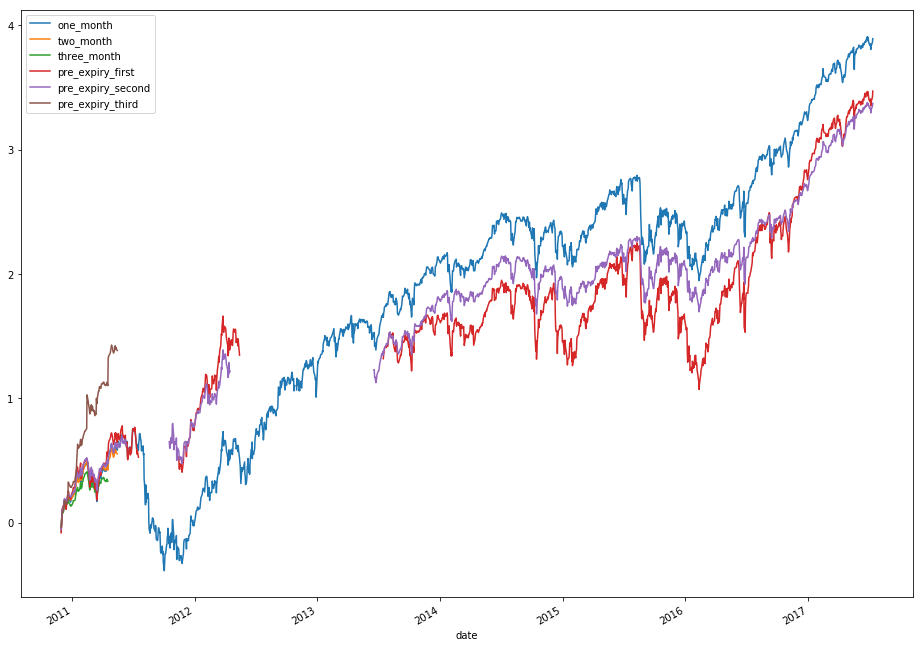

In [21]:
ux_cont_rets.cumsum().plot(figsize=(16, 12))

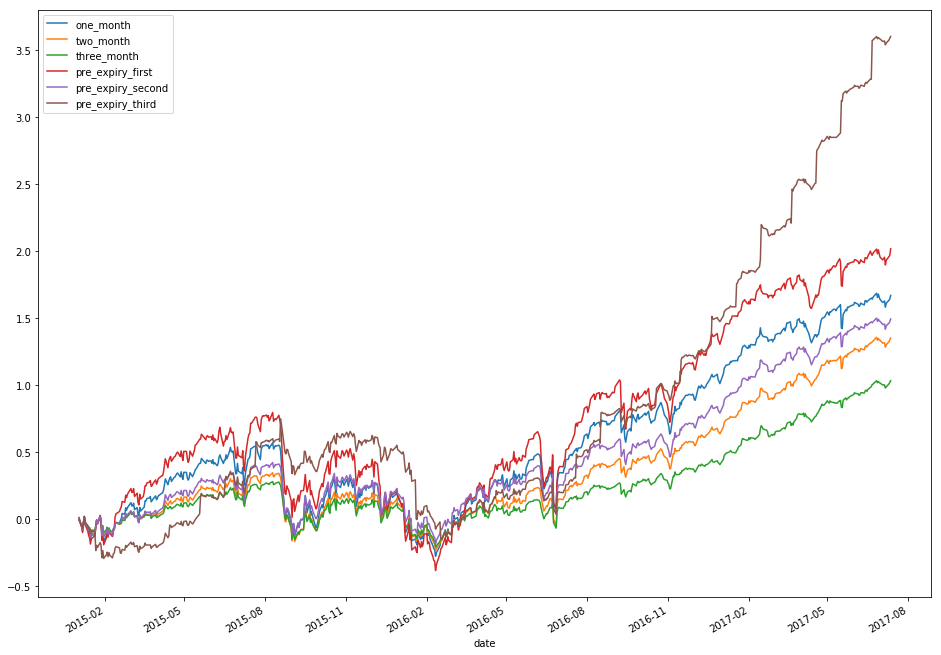

In [22]:
ux_cont_rets.loc["2015":"2017"].cumsum().plot(figsize=(16, 12))

In [23]:
means = ux_cont_rets.mean() * 252
sds = ux_cont_rets.std() * np.sqrt(252)
irs = ux_cont_rets.mean() / ux_cont_rets.std() * np.sqrt(252)
pd.concat([means, sds, irs], axis=1, keys=['mean', 'std', 'IR'])

,mean,std,IR
one_month,0.588919,0.677190,0.869652
two_month,-inf,NaN,NaN
three_month,-inf,NaN,NaN
pre_expiry_first,0.678356,0.753958,0.899726
pre_expiry_second,0.661641,0.550115,1.202733
pre_expiry_third,-inf,NaN,NaN


## Rolling Dollar Risk for holding third contract rolling to expiry

In [24]:
prices.head()

date        contract
2009-06-09  2010UXF     0.0
2009-06-10  2010UXF     0.0
2009-06-11  2010UXF     0.0
2009-06-12  2010UXF     0.0
2009-06-15  2010UXF     0.0
Name: Settle, dtype: float64

In [25]:
MULTIPLIER = 1000
avg_prices = (pre_expiry_roll.loc[:, "UX3"] * prices).groupby(level=0).sum()
rets_cont3 = ux_cont_rets.loc[:, "pre_expiry_third"].fillna(value=0)
dollar_risk = rets_cont3.rolling(252).std(skipna=True) * np.sqrt(252)* avg_prices * MULTIPLIER
dollar_risk = dollar_risk.loc[dollar_risk.first_valid_index():]

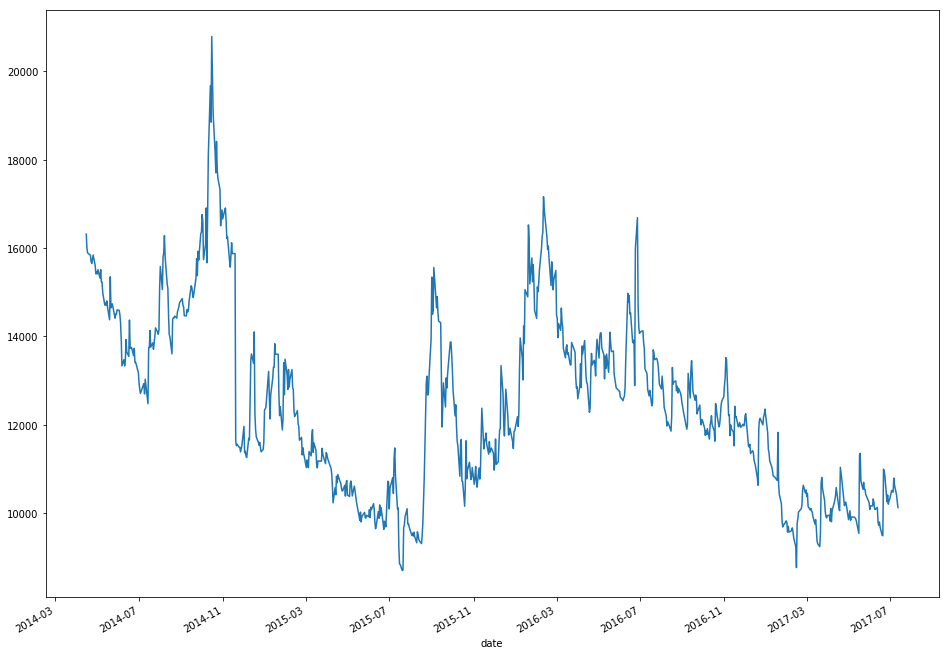

In [26]:
dollar_risk.plot(figsize=(16, 12))